# Labolatorium 5

### Autorzy:
Patryk Klatka \
Wojciech Łoboda

## Generacja macierzy o strukturze opisującej topologię trójwymiarowej siatki zbudowanej z elementów sześciennych 

In [2]:
import numpy as np

def generate(k):
    n = 2 ** (3 * k)
    M = np.zeros((n, n))
    jumps = [0, -1, 1, -2**(k), 2**(k), -2**(k*2), 2**(k*2)]
    for v in range(n):
        for j in jumps:
            if v + j >= 0 and v + j < n:
                M[v][v + j] = 1
    return M * np.random.random((n, n))

## Rekurencyjna procedura kompresji macierzy poszerzona o metody mnożenia macierzy skompresowanej przez wektor i przez inną macierz

### Pseudokod algorytmu mnożenia skompresowanej macierzy przez wektor

```python
def matrix_vector_mult(v, X): 
    if v.sons == Ø: 
        if v.rank == 0: 
            return zeros(size(A).rows) 
        return v.U * (v.V * X) 
    rows = size(X).rows 
    X1 = X[1:rows/2, *] 
    X2 = X[rows/2 + 1 : rows, *] 
    Y11 = matrix_vector_mult(v.sons(1), X1) 
    Y12 = matrix_vector_mult(v.sons(2), X2) 
    Y21 = matrix_vector_mult(v.sons(3), X1) 
    Y22 = matrix_vector_mult(v.sons(4), X2) 
    return [Y11 + Y12, Y21 + Y22]
```


### Pseudokod algorytmu mnożenia skompresowanej macierzy przez macierz
```python
def mult(A,B): 
    if v.sons == 0 and w.sons == 0: 
        if v.rank == 0 and w.rank == 0: 
            return Zero matrix of proper dimentions 
        else if v.rank != 0 and w.rank != 0: 
            return v.U(v.V * w.U) * w.V 
    if v.sons > and w.sons>0: 
        A = [[A1, A2], [A3, A4]] 
        B = [[B1, B2], [B3, B4]]
        return [[mult(A1, B1) + mult(A2, B3), mult(A1, B2) + mult(A2, B4)], [mult(A3, B1) + mult(A4, B3), mult(A3, B2) + mult(A4, B4)]]
    if v.sons == 0 and w.sons > 0: 
        A = U1V1 
        U1 = U1’U1’’ 
        V1 = V1’V1’’ 
        A =  [[U1’  * V1’, U1’  * V1’’ ], [ U1’’  * V1’, U1’’  * V1’’ ]]
        return [[mult(A1, B1) + mult(A2, B3), mult(A1, B2) + mult(A2, B4)], [mult(A3, B1) + mult(A4, B3), mult(A3, B2) + mult(A4, B4)]]
    if v.sons>0 and w = 0: 
        # Analogicznie dla macierzy B
```

In [3]:
from sklearn.utils.extmath import randomized_svd
import numpy as np

class MatrixTree:
    def __init__(self, matrix, row_min, row_max, col_min, col_max):
        self.matrix = matrix
        self.row_min = row_min
        self.row_max = row_max
        self.col_min = col_min
        self.col_max = col_max
        self.leaf = False
        self.children = [None, None, None, None]


    def compress(self, r, eps):
        U, Sigma, V = randomized_svd(self.matrix[self.row_min:self.row_max, self.col_min: self.col_max], n_components=r+1, random_state=0)
        if self.row_min + r == self.row_max or Sigma[r] <= eps:
            self.leaf = True
            self.rank = len(Sigma)
            self.u = U
            self.s = Sigma
            self.v = V
        else:
            self.children = []
            row_newmax = (self.row_min + self.row_max)//2
            col_newmax = (self.col_min + self.col_max)//2
            self.children.append(MatrixTree(self.matrix, self.row_min, row_newmax, self.col_min, col_newmax))
            self.children.append(MatrixTree(self.matrix, self.row_min, row_newmax, col_newmax, self.col_max))
            self.children.append(MatrixTree(self.matrix, row_newmax, self.row_max, self.col_min, col_newmax))
            self.children.append(MatrixTree(self.matrix, row_newmax, self.row_max, col_newmax, self.col_max))

            for child in self.children:
                child.compress(r, eps)
        
    def decompress(self, output_matrix):
        if self.leaf:
            if self.rank != 0:
                sigma = np.zeros((self.rank,self.rank))
                np.fill_diagonal(sigma, self.s)
                output_matrix[self.row_min:self.row_max, self.col_min: self.col_max] = self.u @ sigma @ self.v #zeros
            else:
                output_matrix[self.row_min:self.row_max, self.col_min: self.col_max] = self.matrix[self.row_min:self.row_max, self.col_min: self.col_max]
        else:
            for child in self.children:
                child.decompress(output_matrix)

    @staticmethod
    def multiply_vector(node, vector):
        if node.leaf:
            if node.rank != 0:
                a = node.v @ vector
                b = node.u @ a 
                return (node.u @ (node.v @ vector)) * node.s[0]
            else:
                return node.matrix[node.row_min:node.row_max, node.col_min: node.col_max] @ vector
        else:
            n = len(vector)
            upper, lower = vector[:n//2], vector[n//2:]
            out_upper = MatrixTree.multiply_vector(node.children[0], upper) + MatrixTree.multiply_vector(node.children[1], lower)
            out_lower = MatrixTree.multiply_vector(node.children[2], upper) + MatrixTree.multiply_vector(node.children[3], lower)
            return np.append(out_upper, out_lower, axis=0)
        
    @staticmethod
    def add_matrices(node1, node2):
        result_node = MatrixTree(None, None, None, None, None)

        if node1.leaf and node2.leaf:
            r = node1.u.shape[1]
            u1 = node1.u  @ np.diag(node1.s)
            v1 = node1.v
            u2 = node2.u @ np.diag(node2.s)
            v2 = node2.v

            A = np.append(u1, u2, axis = 1) 
            B = np.append(v1, v2, axis = 0)

            U, S, V = randomized_svd(A @ B, n_components=u1.shape[1])
            
            # Make leaf
            result_node.leaf = True
            result_node.rank = len(S)
            result_node.u = U
            result_node.s = S
            result_node.v = V

            return result_node

        elif node1.leaf or node2.leaf:
            node = node1 if node1.leaf else node2

            n, r = node.u.shape

            u_part = [node.u[:n//2], node.u[n//2:]]
            v_part = [node.v[:,:n//2], node.v[:,n//2:]]

            result_node.children = [MatrixTree(None, None, None, None, None) for _ in range(4)]

            for i in range(2):
                for j in range(2):
                    fake_child = MatrixTree(None, None, None, None, None)
                    fake_child.leaf = True
                    fake_child.rank = r
                    fake_child.u = u_part[i]
                    fake_child.v = v_part[j]
                    fake_child.s = np.ones(r)

                    if node1.leaf:
                        result_node.children[i*2+j] = MatrixTree.add_matrices(fake_child, node2.children[i*2+j])
                    else:
                        result_node.children[i*2+j] = MatrixTree.add_matrices(node1.children[i*2+j], fake_child)

            return result_node
        
        else:
            result_node.children = [MatrixTree(None, None, None, None, None) for _ in range(4)]

            for i in range(4):
                result_node.children[i] = MatrixTree.add_matrices(node1.children[i], node2.children[i])

            return result_node
        

    @staticmethod
    def multiply_matrices(node1, node2):
        result_node = MatrixTree(None, None, None, None, None)

        if node1.leaf and node2.leaf:
            r = node1.u.shape[1]
            u1 = node1.u  @ np.diag(node1.s)
            v1 = node1.v
            u2 = node2.u @ np.diag(node2.s)
            v2 = node2.v

            temp = v1 @ u2
            U = u1 @ temp

            U, V = U.reshape(u1.shape), v2
            
            # Make leaf
            result_node.leaf = True
            result_node.rank = r
            result_node.u = U
            result_node.s = np.ones((r,))
            result_node.v = V

            return result_node

        elif node1.leaf or node2.leaf:
            node = node1 if node1.leaf else node2

            n, r = node.u.shape

            u_part = [node.u[:n//2], node.u[n//2:]]
            v_part = [node.v[:,:n//2], node.v[:,n//2:]]

            fake_children = [MatrixTree(None, None, None, None, None) for _ in range(4)]

            for i in range(4):
                fake_children[i].leaf = True
                fake_children[i].rank = r
                fake_children[i].u = u_part[i//2]
                fake_children[i].v = v_part[i%2]
                fake_children[i].s = np.ones(r)

            result_node.children = [MatrixTree(None, None, None, None, None) for _ in range(4)]

            for i in range(4):
                if node1.leaf:
                    result_node.children[i] = MatrixTree.multiply_matrices(fake_children[i], node2.children[i])
                else:
                    result_node.children[i] = MatrixTree.multiply_matrices(node1.children[i], fake_children[i])

            return result_node
        else:
            result_node.children = [MatrixTree(None, None, None, None, None) for _ in range(4)]

            for i in range(4):
                result_node.children[i] = MatrixTree.multiply_matrices(node1.children[i], node2.children[i])
                
               
            return result_node
        
    @staticmethod
    def update_matrices_for_nodes(root,n):
        root.row_min = 0
        root.row_max = n
        root.col_min = 0
        root.col_max = n
        M = np.zeros((n,n))
        Q = []
        Q.append(root)
        while Q:
            node = Q.pop(0)
            node.matrix = M
            rows = [node.row_min, (node.row_min + node.row_max)//2, node.row_max]
            cols = [node.col_min, (node.col_min + node.col_max)//2, node.col_max]
            for i in range(2):
                for j in range(2):
                    if not node.leaf:
                        node.children[i*2+j].row_min = rows[i]
                        node.children[i*2+j].row_max = rows[i+1]
                        node.children[i*2+j].col_min = cols[j]
                        node.children[i*2+j].col_max = cols[j+1]
                        Q.append(node.children[i*2+j])
        root.decompress(M)

## Rysowacz

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def draw_tree(root, title=''):
    image = np.ones(root.matrix.shape)*255
    Q = deque()
    Q.append(root)
    while Q:
        v = Q.pop()
        if v.leaf:
            image[v.row_min:v.row_max, v.col_min:v.col_min+v.rank] = np.zeros((v.row_max - v.row_min, v.rank))
            image[v.row_min:v.row_min+v.rank, v.col_min:v.col_max] = np.zeros((v.rank , v.col_max - v.col_min))
            image[v.row_min, v.col_min:v.col_max] = np.zeros((1,v.col_max - v.col_min))
            image[v.row_max-1, v.col_min:v.col_max] = np.zeros((1,v.col_max - v.col_min))
            image[v.row_min:v.row_max,v.col_min] = np.zeros(v.row_max-v.row_min)
            image[v.row_min:v.row_max,v.col_max-1] = np.zeros(v.row_max-v.row_min)
        else:
            for child in v.children:
                Q.append(child)

    plt.imshow(image, cmap="gist_gray", vmin=0, vmax=255)
    plt.title(title)
    plt.show()

## Generacja macierzy

In [5]:
k = [2, 3, 4]
test_matrices = [generate(i) for i in k]

In [6]:
for x in test_matrices:
    print(x.shape)

(64, 64)
(512, 512)
(4096, 4096)


## Pomiary mnożenia macierzy przez wektor

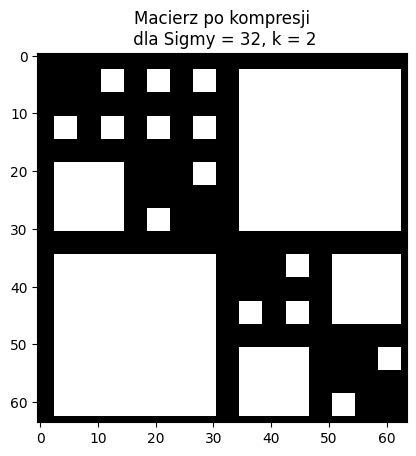

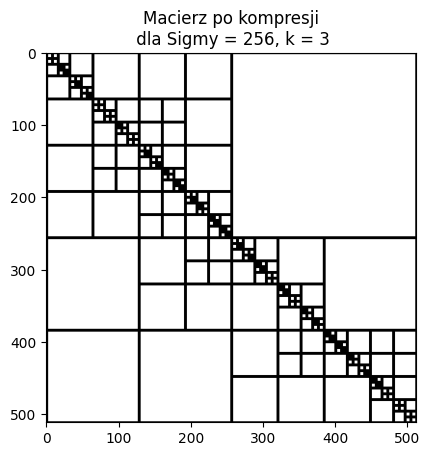

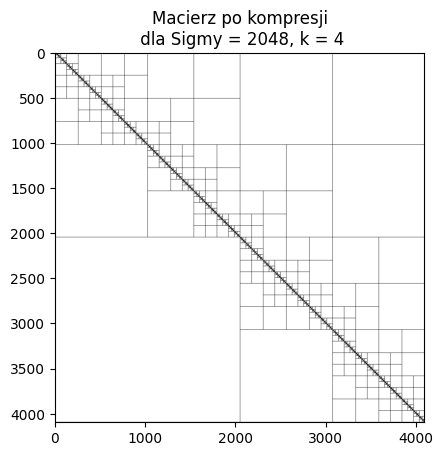

,k,s,time,error
0,2,32,0.001551,13.057959
1,3,256,0.003547,228.234609
2,4,2048,0.011489,2780.754055


In [7]:
from time import perf_counter
from numpy.linalg import svd
import pandas as pd

results = []
for k in [2,3,4]:
    X = generate(k)
    U, Sigma, V = svd(X)
    s = len(Sigma)//2
    root = MatrixTree(X, 0, len(X), 0, len(X[0]))
    root.compress(2, Sigma[s])
    draw_tree(root, f'Macierz po kompresji\n dla Sigmy = {s}, k = {k}')

    st = perf_counter()
    vector = np.random.uniform(low=10**(-8), high=1, size = (2**(3*k), 1))
    result = MatrixTree.multiply_vector(root,vector)
    end = perf_counter()

    N = np.zeros_like(X)
    result_true = X@vector
    err = np.sum(np.square(result - result_true))
    results.append([k, s, end-st, err])

df = pd.DataFrame(results, columns=["k", "s", "time", "error"])
df

## Dopasowanie wykresu $αN^β$ do wyników pomiarów

Exponent k is approximately: 3.7221238429453236
Constant a is approximately: 6.554766111672293e-05


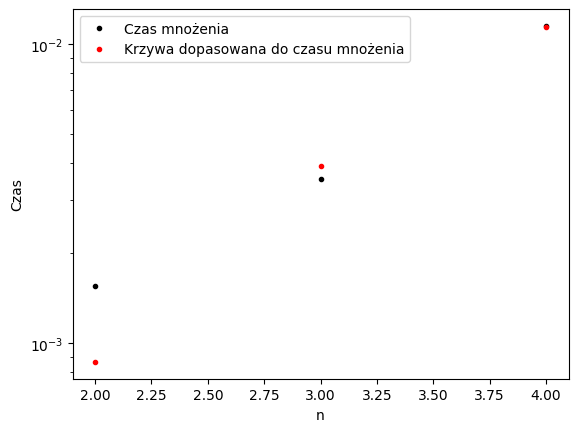

In [8]:
from scipy.optimize import curve_fit

def fit_curve(field1, field2, dataframe):
    x_data = dataframe[field1]
    y_data = dataframe[field2]
    params, covariance = curve_fit(lambda x, a, k: a*x**k, x_data, y_data, p0=[1.0, 1.0])
    a, k = params
    print(f"Exponent k is approximately: {k}")
    print(f"Constant a is approximately: {a}")
    return a, k

def plot_with_fit(a, k, data_frame, name1, name2, name):
    powers = data_frame[name1]
    time = data_frame[name2]

    time_spprox = [a * i ** k for i in powers]
    plt.plot(powers, time, ".", label = f"Czas mnożenia", color="black", )
    plt.plot(powers, time_spprox, ".", label = f"Krzywa dopasowana do czasu mnożenia", color="red")
    plt.xlabel("n")
    plt.ylabel("Czas")
    plt.legend()
    plt.semilogy()
    plt.show()

a, k = fit_curve("k", "time", df)
plot_with_fit(a, k , df, "k", "time", "Bineta")

## Pomiary mnożenia macierzy przez siebie samą

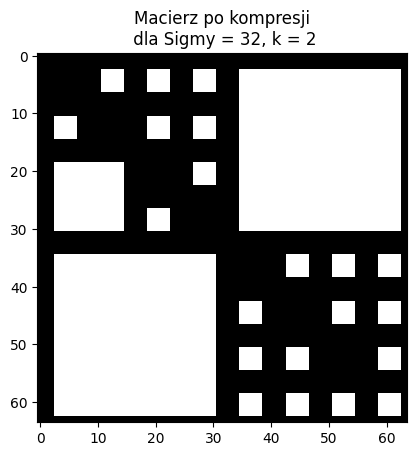

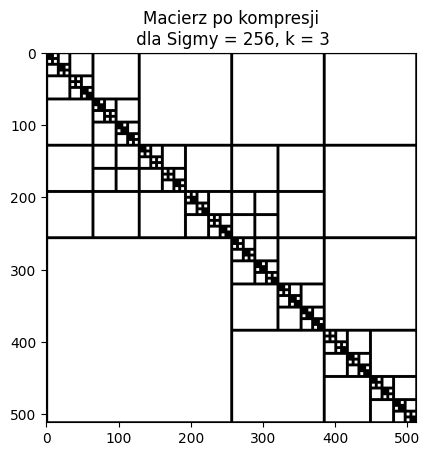

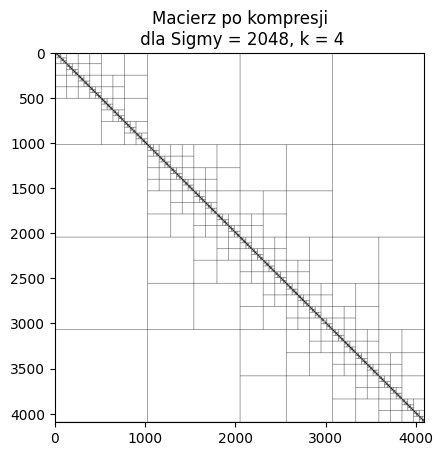

,k,s,time,error
0,2,32,0.001403,466.975751
1,3,256,0.006201,3703.520176
2,4,2048,0.016475,31292.369174


In [10]:
results = []
for k in [2,3,4]:
    X = generate(k)
    U, Sigma, V = svd(X)
    s = len(Sigma)//2
    root = MatrixTree(X, 0, len(X), 0, len(X[0]))
    root.compress(2, Sigma[s])
    draw_tree(root, f'Macierz po kompresji\n dla Sigmy = {s}, k = {k}')

    st = perf_counter()
    result = MatrixTree.multiply_matrices(root,root)
    end = perf_counter()

    # error
    N = np.zeros_like(X)
    result_true = X@X
    MatrixTree.update_matrices_for_nodes(result, 2**(3*k))
    err = np.sum(np.square(result.matrix - result_true))
    results.append([k, s, end-st, err])

df = pd.DataFrame(results, columns=["k", "s", "time", "error"])
df

Exponent k is approximately: 3.439143046264159
Constant a is approximately: 0.0001401703116344666


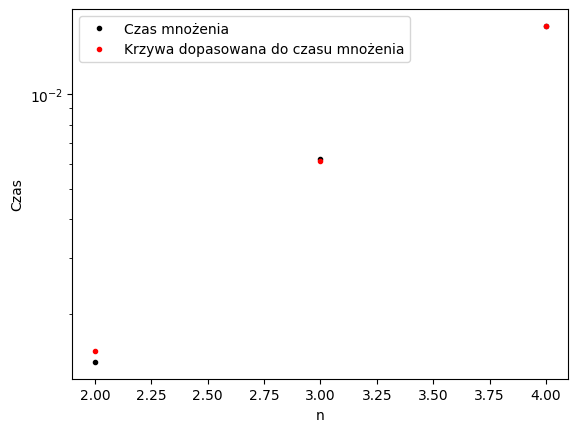

In [11]:
a, k = fit_curve("k", "time", df)
plot_with_fit(a, k , df, "k", "time", "Bineta")